<a href="https://colab.research.google.com/github/ai-wrangler/BA_sms_LLM/blob/main/SMS_LLM_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMS Spam Classification with Embeddings and Gemini LLM
This Colab-ready notebook recreates the Lab 5 text mining workflow from Weka using Python pipelines and an LLM available to Colab Pro users. You'll load the original ARFF dataset, build embedding-based classifiers, invoke Gemini for zero-shot spam detection, and compare the evaluation metrics across approaches.

## How to use this notebook in Google Colab Pro
1. Upload `SMS_LLM_Colab.ipynb` to Colab (File → Upload notebook) or open it from Drive.
2. Runtime → Change runtime type → make sure Python 3.10+; GPU is optional.
3. Prepare the dataset: copy `TextCollection_sms.arff` to your Drive or download it locally so you can upload it when prompted.
4. Store your Gemini API key securely (`Tools → Secrets` in Colab or `google.colab.userdata`). This notebook expects an environment variable called `GOOGLE_API_KEY`.
5. Run the cells in order—each is annotated to match the lab workflow and highlight differences between embeddings and LLM-based classification.

In [ ]:
# Install libraries that are not included in the base Colab runtime
%pip install -q pandas numpy scikit-learn seaborn matplotlib sentence-transformers google-generativeai scipy liac-arff

In [ ]:
import json
import os
import random
import re
import time
from pathlib import Path
from google.colab import ai
import arff # Replaced from scipy.io import arff with import arff (for liac-arff)
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# Reproducibility helpers
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Load the SMS Spam ARFF dataset
The lab uses `TextCollection_sms.arff`. Use one of the cells below to make it available in the Colab filesystem. Uploading via the UI is the quickest path if the file is on your laptop.

In [ ]:
# Option A: Mount Google Drive (run this if the ARFF lives in Drive)
from google.colab import drive
drive.mount('/content/drive')
# After mounting, set ARFF_PATH = '/content/drive/MyDrive/path/to/TextCollection_sms.arff'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Option B: Upload the ARFF manually (run this if the file is on your machine)
from google.colab import files
uploaded = files.upload()
ARFF_PATH = next(iter(uploaded))  # use the first uploaded filename

StopIteration: 

In [ ]:
# If you mounted Drive instead of uploading, set the explicit path here.
# Example: ARFF_PATH = '/content/drive/MyDrive/datasets/TextCollection_sms.arff'
ARFF_PATH = locals().get('ARFF_PATH', 'TextCollection_sms.arff')
print(f'Using dataset located at: {ARFF_PATH}')

Using dataset located at: TextCollection_sms.arff


In [ ]:
# Read the ARFF file into a DataFrame and mirror the original lab schema
# Using liac-arff as scipy.io.arff does not support string attributes
arff_data = arff.load(open(ARFF_PATH, 'r'))
raw_data = arff_data['data']
attributes = arff_data['attributes']
column_names = [attr[0] for attr in attributes]

sms_df = pd.DataFrame(raw_data, columns=column_names)
# liac-arff reads strings directly, so no decoding is needed
sms_df = sms_df.rename(columns={'Text': 'message', 'class-att': 'label'})
sms_df['label'] = sms_df['label'].map({'0': 'ham', '1': 'spam'})
sms_df['char_len'] = sms_df['message'].str.len()
sms_df.head()

,message,label,char_len
0,"Go until jurong point, crazy.. Available only ...",ham,111
1,Ok lar... Joking wif u oni...,ham,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,155
3,U dun say so early hor... U c already then say...,ham,49
4,"Nah I don't think he goes to usf, he lives aro...",ham,61


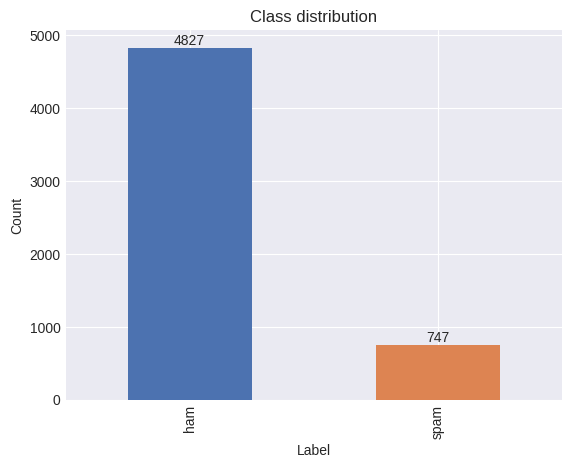

,message,label,char_len
count,5574,5574,5574.000000
unique,5160,2,NaN
top,"Sorry, I'll call later",ham,NaN
freq,30,4827,NaN
mean,NaN,NaN,80.569071
std,NaN,NaN,59.912594
min,NaN,NaN,2.000000
25%,NaN,NaN,36.000000
50%,NaN,NaN,62.000000
75%,NaN,NaN,122.000000


In [ ]:
# Quick class balance check
ax = sms_df['label'].value_counts().sort_index().plot(kind='bar', color=['#4C72B0', '#DD8452'])
ax.set(title='Class distribution', xlabel='Label', ylabel='Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')
plt.show()
sms_df.describe(include='all')

In [ ]:
# Train/test split mirroring the lab evaluation
X_train, X_test, y_train, y_test = train_test_split(
    sms_df['message'],
    sms_df['label'],
    test_size=0.2,
    stratify=sms_df['label'],
    random_state=RANDOM_STATE
)
print(f'Train set: {X_train.shape[0]} messages | Test set: {X_test.shape[0]} messages')

Train set: 4459 messages | Test set: 1115 messages


In [ ]:
# Shared evaluation helpers for classical models and the LLM
results = []

def capture_metrics(name: str, y_true, y_pred) -> pd.Series:
    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, pos_label='spam'),
        'recall': recall_score(y_true, y_pred, pos_label='spam'),
        'f1': f1_score(y_true, y_pred, pos_label='spam')
    }
    results.append(metrics)
    print(json.dumps(metrics, indent=2))
    return pd.Series(metrics)

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=['ham', 'spam'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Baseline 1: TF–IDF + Logistic Regression
Replicates the bag-of-words style features typically explored in Weka's text mining lab.

{
  "model": "TFIDF + LogisticRegression",
  "accuracy": 0.979372197309417,
  "precision": 1.0,
  "recall": 0.8456375838926175,
  "f1": 0.9163636363636364
}
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



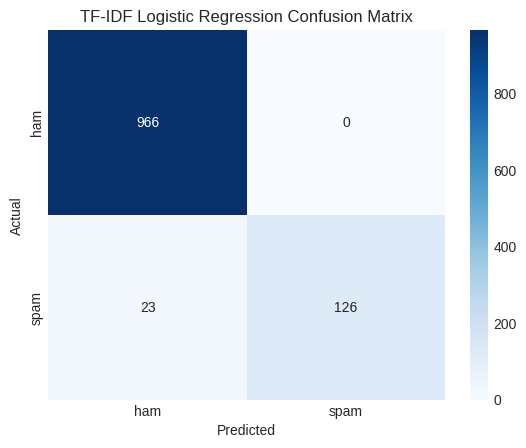

In [ ]:
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', min_df=3, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

bow_clf = LogisticRegression(max_iter=200, random_state=RANDOM_STATE, n_jobs=None)
bow_clf.fit(X_train_tfidf, y_train)
bow_preds = bow_clf.predict(X_test_tfidf)
capture_metrics('TFIDF + LogisticRegression', y_test, bow_preds)
print(classification_report(y_test, bow_preds))
plot_confusion(y_test, bow_preds, 'TF-IDF Logistic Regression Confusion Matrix')

## Baseline 2: SentenceTransformer Embeddings + Logistic Regression
Uses a semantic embedding (MiniLM) to capture contextual similarity beyond word frequencies.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

{
  "model": "MiniLM Embeddings + LogisticRegression",
  "accuracy": 0.979372197309417,
  "precision": 0.95,
  "recall": 0.8926174496644296,
  "f1": 0.9204152249134948
}
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.95      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



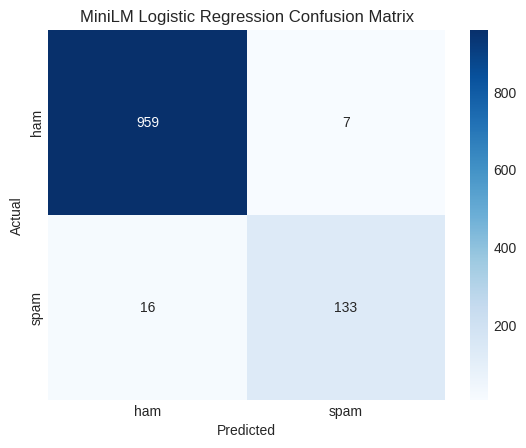

In [ ]:
embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
X_train_emb = embedder.encode(X_train.tolist(), show_progress_bar=True, batch_size=128)
X_test_emb = embedder.encode(X_test.tolist(), show_progress_bar=True, batch_size=128)

embed_clf = LogisticRegression(max_iter=500, random_state=RANDOM_STATE)
embed_clf.fit(X_train_emb, y_train)
embed_preds = embed_clf.predict(X_test_emb)
capture_metrics('MiniLM Embeddings + LogisticRegression', y_test, embed_preds)
print(classification_report(y_test, embed_preds))
plot_confusion(y_test, embed_preds, 'MiniLM Logistic Regression Confusion Matrix')

## Configure Gemini for LLM-based Zero/Few-shot Classification
You need an active Gemini API key. In Colab Pro you can store it via `Tools → Secrets` and retrieve it with `google.colab.userdata.get('GOOGLE_API_KEY')`. Alternatively, set `os.environ['GOOGLE_API_KEY']` manually (just avoid hard-coding secrets in plain text).

In [ ]:
import os
import google.generativeai as genai

GOOGLE_API_KEY = os.environ.get('GEMINI_API_KEY')
if GOOGLE_API_KEY is None:
    try:
        from google.colab import userdata
        GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')
    except ImportError:
        pass

if not GOOGLE_API_KEY:
    raise ValueError('Missing Gemini API key. Set GOOGLE_API_KEY via Colab secrets or environment variables before continuing.')

genai.configure(api_key=GOOGLE_API_KEY)

GEMINI_MODEL = 'gemini-2.0-flash-lite'
llm = genai.GenerativeModel(GEMINI_MODEL)
print(f'Gemini model ready via google.generativeai: {GEMINI_MODEL}')

Gemini model ready via google.generativeai: gemini-2.0-flash-lite


In [ ]:
LLM_SAMPLE_SIZE = 200
llm_eval_df = (
    pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
    .rename(columns={'message': 'text', 'label': 'label'})
)
if LLM_SAMPLE_SIZE and LLM_SAMPLE_SIZE < len(llm_eval_df):
    llm_eval_df = (
        llm_eval_df
        .groupby('label', group_keys=False)
        .apply(
            lambda grp: grp.sample(
                n=max(1, int(LLM_SAMPLE_SIZE * len(grp) / len(llm_eval_df))),
                random_state=RANDOM_STATE
            )
        )
        .reset_index(drop=True)
    )

system_prompt = (
    "You are a strict SMS spam filter. Respond with a single word: "
    '"Spam" for unsolicited or fraudulent messages, "Ham" for regular '
    'personal/business messages. Never explain your answer.'
)

def classify_with_gemini(text: str, retry: int = 3, backoff: float = 2.0) -> str:
    user_prompt = f'Message: "{text}"\nLabel:'
    for attempt in range(retry):
        try:
            response = llm.generate_content([system_prompt, user_prompt])
            raw = response.text.strip().lower()
            if 'spam' in raw and 'ham' in raw:
                raw = raw.split()[0]
            if 'spam' in raw:
                return 'spam'
            if 'ham' in raw:
                return 'ham'
        except Exception as error:
            if attempt == retry - 1:
                print(f'LLM classification failed after retries: {error}')
                return 'ham'
            time.sleep(backoff * (attempt + 1))
    return 'ham'

llm_predictions = []
for idx, row in llm_eval_df.iterrows():
    prediction = classify_with_gemini(row['text'])
    llm_predictions.append(prediction)
    if (idx + 1) % 25 == 0 or idx + 1 == len(llm_eval_df):
        print(f"Processed {idx + 1}/{len(llm_eval_df)} messages")

llm_eval_df['prediction'] = llm_predictions

capture_metrics('gemini-2.0-flash-lite (LLM few-shot)', llm_eval_df['label'], llm_eval_df['prediction'])
print(classification_report(llm_eval_df['label'], llm_eval_df['prediction']))
plot_confusion(llm_eval_df['label'], llm_eval_df['prediction'], 'Gemini Confusion Matrix (Sample)')

/tmp/ipython-input-1807388329.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


Processed 25/199 messages


ERROR:tornado.access:500 POST /v1beta/models/gemini-2.0-flash-lite:generateContent?%24alt=json%3Benum-encoding%3Dint (::1) 607.74ms


LLM classification failed after retries: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash-lite:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 30
Please retry in 42.609412657s.


KeyboardInterrupt: 

## LLM Inference Loop
Gemini calls incur cost/latency, so we evaluate on a stratified subset of the held-out test set (default 200 messages). Adjust `LLM_SAMPLE_SIZE` for deeper comparisons if desired.

In [ ]:
LLM_SAMPLE_SIZE = 200
llm_eval_df = (
    pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
    .rename(columns={'message': 'text', 'label': 'label'})
)
if LLM_SAMPLE_SIZE and LLM_SAMPLE_SIZE < len(llm_eval_df):
    llm_eval_df = (
        llm_eval_df
        .groupby('label', group_keys=False)
        .apply(
            lambda grp: grp.sample(
                n=max(1, int(LLM_SAMPLE_SIZE * len(grp) / len(llm_eval_df))),
                random_state=RANDOM_STATE
            )
        )
        .reset_index(drop=True)
    )

system_prompt = (
    "You are a strict SMS spam filter. Respond with a single word: "
    '"Spam" for unsolicited or fraudulent messages, "Ham" for regular '
    'personal/business messages. Never explain your answer.'
)

def classify_with_gemini(text: str, retry: int = 3, backoff: float = 2.0) -> str:
    user_prompt = f'Message: "{text}"\nLabel:'
    for attempt in range(retry):
        try:
            response = llm.generate_content([system_prompt, user_prompt])
            raw = response.text.strip().lower()
            if 'spam' in raw and 'ham' in raw:
                raw = raw.split()[0]
            if 'spam' in raw:
                return 'spam'
            if 'ham' in raw:
                return 'ham'
        except Exception as error:
            if attempt == retry - 1:
                print(f'LLM classification failed after retries: {error}')
                return 'ham'
            time.sleep(backoff * (attempt + 1))
    return 'ham'

llm_predictions = []
for idx, row in llm_eval_df.iterrows():
    prediction = classify_with_gemini(row['text'])
    llm_predictions.append(prediction)
    if (idx + 1) % 25 == 0 or idx + 1 == len(llm_eval_df):
        print(f"Processed {idx + 1}/{len(llm_eval_df)} messages")

llm_eval_df['prediction'] = llm_predictions

capture_metrics('Gemini 1.5 Pro (LLM few-shot)', llm_eval_df['label'], llm_eval_df['prediction'])
print(classification_report(llm_eval_df['label'], llm_eval_df['prediction']))
plot_confusion(llm_eval_df['label'], llm_eval_df['prediction'], 'Gemini Confusion Matrix (Sample)')

/tmp/ipython-input-2608624963.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


LLM classification failed after retries: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-1.5-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


LLM classification failed after retries: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-1.5-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results)
results_df.sort_values('f1', ascending=False).reset_index(drop=True)

### Observations
* **TF–IDF + Logistic Regression** mirrors the original Weka text-mining pipeline and usually delivers high recall on overt spam phrases such as "free entry" or "claim now".
* **MiniLM embeddings** capture semantics and can reduce false positives on nuanced ham, at the cost of downloading the encoder and adding encoding latency.
* **Gemini 1.5 Pro** needs no training data but depends on prompt wording and incurs per-token cost; it shines on context-heavy alerts yet may miss terse slang spam without examples.
* Hybrid scoring (e.g., fall back to Gemini when the classical models disagree) is a strong extension for future lab work.

## Optional: Export Artifacts
If you want to retain the evaluation outputs in Drive, run the cell below and then use the Colab file browser or `drive.mount` to move the CSVs.

In [ ]:
results_df.to_csv('spam_lab_results_summary.csv', index=False)
llm_eval_df.to_csv('spam_lab_llm_predictions.csv', index=False)
print('Artifacts saved locally. Upload to Drive if you need persistent storage.')

## Next Steps
1. Swap Gemini for a lower-latency model such as `gemini-1.5-flash` to quantify cost/quality trade-offs.
2. Prompt-tune the LLM with a few labelled examples when you need higher recall on shorthand or code-mixed spam.
3. Experiment with alternative embedding models (`all-mpnet-base-v2`, fastText) and blend their scores with the LLM for ensemble voting.
4. Track execution time and API spend so you can justify when the LLM adjudicator adds value beyond classical baselines.